In [1]:
pip install geodatasets

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /nfs/knight/mamba_aug23/envs/jan24_env/lib/python3.11/site-packages/cdat_info-8.2.1-py3.9.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


Fetching data for 250501...
Fetching data for 250502...
Fetching data for 250503...
Fetching data for 250504...
Fetching data for 250505...
Fetching data for 250506...
Fetching data for 250507...
Fetching data for 250508...
Fetching data for 250509...
Fetching data for 250510...
Fetching data for 250511...
Fetching data for 250512...
Fetching data for 250513...
Fetching data for 250514...
Fetching data for 250515...
Fetching data for 250516...
Fetching data for 250517...
Fetching data for 250518...
Fetching data for 250519...
Fetching data for 250520...
Fetching data for 250521...
Fetching data for 250522...
Fetching data for 250523...
Fetching data for 250524...
Fetching data for 250525...
Fetching data for 250526...
Fetching data for 250527...
Fetching data for 250528...
Fetching data for 250529...
Fetching data for 250530...
Fetching data for 250531...
Fetching data for 250601...
Fetching data for 250602...
Fetching data for 250603...
Fetching data for 250604...
Fetching data for 25

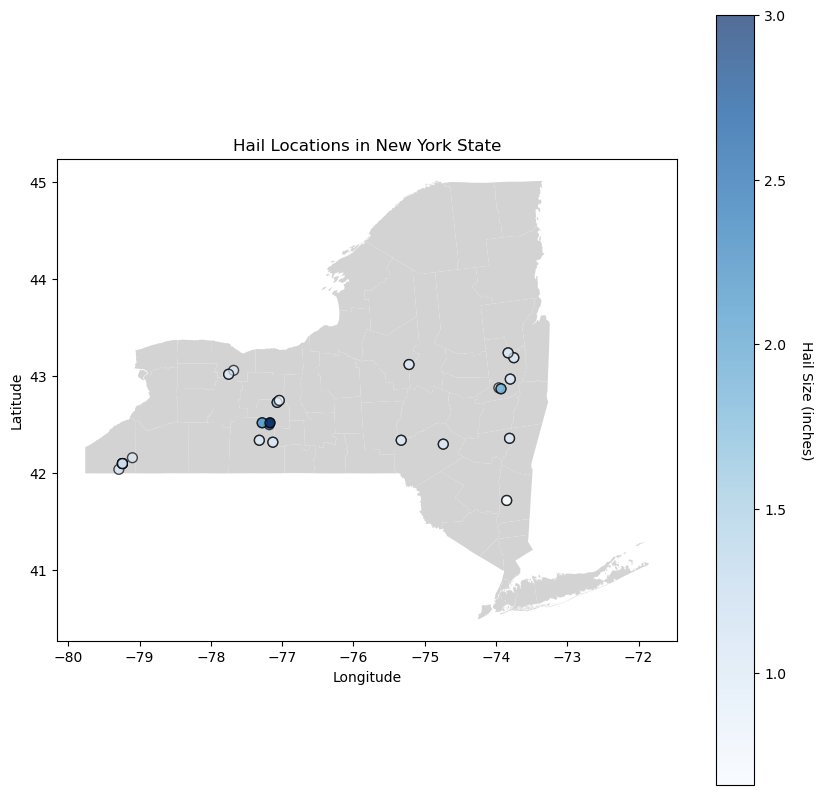

In [6]:
import os
import requests
import pandas as pd
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# Set the path to PROJ library (if needed for GeoPandas)
os.environ['PROJ_LIB'] = '/usr/share/proj'  # Update this path if needed

# Load New York State shapefile (adjust the path as necessary)
ny_counties_map = gpd.read_file("/nfs/home11/ugrad/2024/es348865/Current_Code_projects/swrcc_code/shapefiles_code/state/NYS_Counties.shp")
#Current_Code_projects/swrcc_code/shapefiles_code/state/NYS_Counties.shp

# Function to fetch hail data from NOAA for a specific date
def fetch_hail_data(date_str):
    """Fetches hail data for a specific date from NOAA's storm reports page."""
    url = f'https://www.spc.noaa.gov/climo/reports/{date_str}_rpts.html'
    response = requests.get(url)
    return response.content

def parse_hail_reports(content):
    """Parses the HTML content to extract hail reports (including size, county, and location)."""
    reports = []
    soup = BeautifulSoup(content, 'html.parser')
    rows = soup.find_all('tr')
    
    for row in rows:
        cols = row.find_all('td')  # Extract columns for this row
        
        # Ensure that we have enough columns and that this row belongs to New York (NY)
        if len(cols) > 5 and 'NY' in cols[4].text:
            size_str = cols[1].text.strip()  # Size of the hail
            try:
                size = float(size_str) / 100  # Convert size from hundredths of an inch to inches
                county = cols[3].text.strip()
                
                # Extract latitude and longitude and divide by 100 to insert the decimal point
                lat_str = cols[5].text.strip()
                lon_str = cols[6].text.strip()
                
                # Convert latitude and longitude from integer format to decimal degrees
                latitude = int(lat_str) / 100.0
                longitude = -int(lon_str) / 100.0  # Negate to indicate western longitude
                
                # Append the report data to the list
                reports.append((county, size, latitude, longitude))
            except ValueError:
                continue  # Skip any rows that don't have valid size data or coordinates
    return reports



# Function to collect hail data over a range of dates and store it
def collect_hail_data(start_date, end_date, output_file):
    """Fetches and parses hail data for each day within the specified date range."""
    hail_events = []  # List to store hail events

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%y%m%d')
        print(f'Fetching data for {date_str}...')
        
        # Fetch and parse hail data for the current date
        content = fetch_hail_data(date_str)
        hail_reports = parse_hail_reports(content)
        
        # Add the hail reports to the list
        hail_events.extend(hail_reports)
        
        current_date += datetime.timedelta(days=1)

    # Create a DataFrame to store the hail events
    hail_events_df = pd.DataFrame(hail_events, columns=['County', 'Size', 'Latitude', 'Longitude'])
    
    # Save the DataFrame to a CSV file
    hail_events_df.to_csv(output_file, index=False)
    print(f"Hail event data saved to '{output_file}'")

# Function to plot hail locations on a map of New York State
# Ensure the NY counties map is in WGS84 (latitude/longitude) format
ny_counties_map = ny_counties_map.to_crs(epsg=4326)  # EPSG:4326 is WGS84

def plot_hail_locations(hail_data_file):
    """Plots the locations of hail events on a map of New York."""
    # Load hail event data
    hail_events = pd.read_csv(hail_data_file)
    
    # Create a plot with the map of New York counties
    fig, ax = plt.subplots(figsize=(10, 10))
    ny_counties_map.plot(ax=ax, color='lightgrey')  # Draw counties as background
    
    # Plot the hail event locations as points
    scatter = ax.scatter(hail_events['Longitude'], hail_events['Latitude'], 
                         c=hail_events['Size'], cmap='Blues', s=50, edgecolor='k', alpha=0.7)
    
    # Add a colorbar to indicate hail size
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Hail Size (inches)', rotation=270, labelpad=20)
    
    # Set plot labels and title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Hail Locations in New York State")
    
    # Show the plot
    plt.show()


# Example usage to fetch and plot hail data for the past month
start_date = datetime.datetime(2025, 5, 1)
end_date = datetime.datetime.now()
output_file = "hail_events_ny.csv"

# Collect hail data and save to CSV
collect_hail_data(start_date, end_date, output_file)

# Plot the hail event locations
plot_hail_locations(output_file)